<h1 style="text-align:center;">Curate YF negatives</h1>
- Sequences <br>
- AF3 predictions (standard + single chain mode) <br>
- compute AUROC

In [18]:
import glob
import os
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

# Curate sequences

In [44]:
topdir = '/Users/roessner/Documents/PostDoc/Data/TCR_data/Repertoires/'
df = pd.read_parquet(f"{topdir}/df_sel_studies_ireceptor_pairs_allele_and_NO_allele_merged.parquet")

n_total = 1000
studies = df['study_id'].unique()
n_per_study = max(1, n_total // len(studies))

samples = []

for study in studies:
    study_df = df[df['study_id'] == study]
    
    subjects = study_df['subject_id'].unique()
    n_per_subject = max(1, n_per_study // len(subjects))
    
    sampled_study = (
        study_df.groupby('subject_id', group_keys=False)
                .apply(lambda x: x.sample(min(len(x), n_per_subject), random_state=42))
    )
    
    samples.append(sampled_study)

sampled = pd.concat(samples)
sampled = sampled.sample(min(len(sampled), 1000), random_state=42)[['TRAV', 'TRAJ', 'TRBV', 'TRBJ', 'cdr3_TRA', 'cdr3_TRB']]
sampled.insert(0, 'id', [f'tcr_{i:04d}' for i in range(1, len(sampled) + 1)])
sampled['peptide'] = 'LLWNGPMAV'
sampled['MHC'] = 'HLA_A0201'
sampled['species'] = 'HomoSapiens'
sampled.to_csv('YF_neg_repertoire_AF3_input.csv', index=False)

chains = ['A', 'B'] 
for chain in chains:
    if chain == 'A':
        df_chain = sampled.drop(columns=['TRBV', 'TRBJ','cdr3_TRB'])
        df_chain.to_csv(f'YF_neg_repertoire_AF3_chainA_input.csv', index=False)
    else:
        df_chain = sampled.drop(columns=['TRAV', 'TRAJ','cdr3_TRA'])
        df_chain.to_csv(f'YF_neg_repertoire_AF3_chainB_input.csv', index=False)


/var/folders/2v/m8p5rbh538sgyrgvrcyb210h0000gn/T/ipykernel_5844/1087369600.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(len(x), n_per_subject), random_state=42))
/var/folders/2v/m8p5rbh538sgyrgvrcyb210h0000gn/T/ipykernel_5844/1087369600.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(len(x), n_per_subject), random_state=42))
/var/folde

# AUROC

In [33]:
df = pd.read_csv(f'YF_neg_repertoire_AF3_output.txt', delim_whitespace=True)[['id', 'AF3_iptm_pair_mean']]

# annotate sequence
anno = pd.read_csv(f'YF_neg_repertoire_AF3_input.csv')
anno = anno.drop(columns=['peptide', 'MHC', 'species'])

df = pd.merge(df, anno, on='id')

chains = ['A', 'B']

for chain in chains:
    df_chain = pd.read_csv(f'YF_neg_repertoire_AF3_chain{chain}_output.txt', delim_whitespace=True)[['id', 'AF3_iptm_pair_mean']]
    df_chain = df_chain.rename(columns={'AF3_iptm_pair_mean': f'chain{chain}_AF3_iptm_pair_mean'})

    # annotate sequence
    anno = pd.read_csv(f'YF_neg_repertoire_AF3_chain{chain}_input.csv')
    anno = anno.drop(columns=['peptide', 'MHC', 'species'])
    
    df_chain = pd.merge(df_chain, anno, on='id')
    df_chain = df_chain.rename(columns={'id': f'chain{chain}_id'})
    
    # merge with original double chain data
    if chain == 'A':
        df = pd.merge(df, df_chain, how='left', on=['TRAV', 'TRAJ','cdr3_TRA'])
    else:
        df = pd.merge(df, df_chain, how='left', on=['TRBV', 'TRBJ','cdr3_TRB'])

df.to_pickle('YF_neg_repertoire_AF3_double_and_single_chain.pkl')


/var/folders/2v/m8p5rbh538sgyrgvrcyb210h0000gn/T/ipykernel_3206/1827090056.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(f'YF_neg_repertoire_AF3_output.txt', delim_whitespace=True)[['id', 'AF3_iptm_pair_mean']]
/var/folders/2v/m8p5rbh538sgyrgvrcyb210h0000gn/T/ipykernel_3206/1827090056.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_chain = pd.read_csv(f'YF_neg_repertoire_AF3_chain{chain}_output.txt', delim_whitespace=True)[['id', 'AF3_iptm_pair_mean']]
/var/folders/2v/m8p5rbh538sgyrgvrcyb210h0000gn/T/ipykernel_3206/1827090056.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_chain = pd.read_csv(f'YF_neg_repertoire_AF3_chain{chain}_output.txt', delim_whitespace=

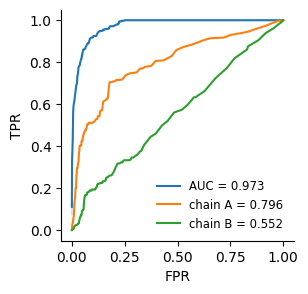

In [35]:
df1 = pd.read_pickle('../260218_YF-modes_AF3-single-chain/AF3_double_and_single_chain.pkl')
df2 = pd.read_pickle('YF_neg_repertoire_AF3_double_and_single_chain.pkl')

lst = ['std', 'chainA', 'chainB']

fig, ax = plt.subplots(1,1,figsize=(3,3))

for i in lst:
    # extract scores
    if i == 'std':
        scores_pos = df1["AF3_iptm_pair_mean"].values
        scores_neg = df2["AF3_iptm_pair_mean"].values
    else:
        scores_pos = df1[f"{i}_AF3_iptm_pair_mean"].values
        scores_neg = df2[f"{i}_AF3_iptm_pair_mean"].values

    

    # create labels
    y_true = np.concatenate([
        np.ones(len(scores_pos)),      # positives = 1
        np.zeros(len(scores_neg))      # negatives = 0
    ])

    # combine scores
    y_scores = np.concatenate([scores_pos, scores_neg])

    # compute ROC
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    auc = roc_auc_score(y_true, y_scores)

    if i == 'std':
        label = 'AUC'
    else:
        label = f'{i[:-1]} {i[-1:]}'

    sns.lineplot(x=fpr, y=tpr, label=f"{label} = {auc:.3f}", ax=ax)

ax.legend(frameon=False, fontsize='small')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
sns.despine()

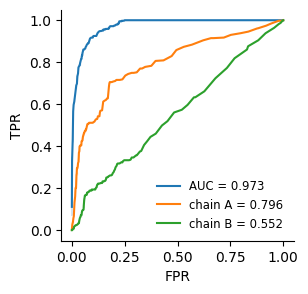

In [36]:
df1 = pd.read_pickle('../260218_YF-modes_AF3-single-chain/AF3_double_and_single_chain.pkl')
df2 = pd.read_pickle('YF_neg_repertoire_AF3_double_and_single_chain.pkl')

lst = ['std', 'chainA', 'chainB']

fig, ax = plt.subplots(1,1,figsize=(3,3))

for i in lst:
    # extract scores
    if i == 'std':
        scores_pos = df1["AF3_iptm_pair_mean"].values
        scores_neg = df2["AF3_iptm_pair_mean"].values
    else:
        scores_pos = df1[f"{i}_AF3_iptm_pair_mean"].values
        scores_neg = df2[f"{i}_AF3_iptm_pair_mean"].values

    

    # create labels
    y_true = np.concatenate([
        np.ones(len(scores_pos)),      # positives = 1
        np.zeros(len(scores_neg))      # negatives = 0
    ])

    # combine scores
    y_scores = np.concatenate([scores_pos, scores_neg])

    # compute ROC
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    auc = roc_auc_score(y_true, y_scores)

    if i == 'std':
        label = 'AUC'
    else:
        label = f'{i[:-1]} {i[-1:]}'

    sns.lineplot(x=fpr, y=tpr, label=f"{label} = {auc:.3f}", ax=ax)

ax.legend(frameon=False, fontsize='small')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
sns.despine()

957


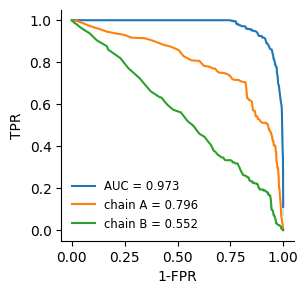

In [ ]:
df1 = pd.read_pickle('../260218_YF-modes_AF3-single-chain/AF3_double_and_single_chain.pkl')
df2 = pd.read_pickle('YF_neg_repertoire_AF3_double_and_single_chain.pkl')

lst = ['std', 'chainA', 'chainB']

fig, ax = plt.subplots(1,1,figsize=(3,3))

for i in lst:
    # extract scores
    if i == 'std':
        scores_pos = df1["AF3_iptm_pair_mean"].values
        scores_neg = df2["AF3_iptm_pair_mean"].values
    else:
        scores_pos = df1[f"{i}_AF3_iptm_pair_mean"].values
        scores_neg = df2[f"{i}_AF3_iptm_pair_mean"].values

    

    # create labels
    y_true = np.concatenate([
        np.ones(len(scores_pos)),      # positives = 1
        np.zeros(len(scores_neg))      # negatives = 0
    ])

    # combine scores
    y_scores = np.concatenate([scores_pos, scores_neg])

    # compute ROC
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    auc = roc_auc_score(y_true, y_scores)

    if i == 'std':
        label = 'AUC'
    else:
        label = f'{i[:-1]} {i[-1:]}'

    sns.lineplot(x=1-fpr, y=tpr, label=f"{label} = {auc:.3f}", ax=ax)

ax.legend(frameon=False, fontsize='small')
ax.set_xlabel('1-FPR')
ax.set_ylabel('TPR')
sns.despine()